# **SDSE Final Project: Predicting Car Fuel Efficiency with Machine Learning**

Our notebook attempts to predict a given car's **combined fuel efficiency (MPG)** based on information that is available **before** buying the car:

- Make and type                 (SUV, sedan, etc.)
- Drivetrain                    (FWD, AWD, etc.)
- Engine displacement           (L)
- Number of cylinders           (dimensinoless)
- Transmission type             (automatic, manual, etc.)

Why this matters:

- Consumers can estimate real-world fuel costs for a car model even when independent test results are not widely available yet, such with new vehicle models and trims.
- Dealerships and fleet managers can compare many options quickly based on expected efficiency.
- Policy or sustainability teams can more immediately simulate how changing the mix of vehicles (more small engines, more hybrids, etc.) might affect fuel consumption and greenhouse/noise emissions.

The notebook follows the outline specified for the project submissions in the lab session. 

0. Choose performance metric
1. load data
2. split off the test data set
3. Choose the families of model and hyperparameter variations to test.
4. Execute (train and evaluate) models
5. Choose best model and evaluate with test data.

# 0. Performance metric:

Since we are working with a regression model, we will be using the R^2 coefficient of determination as the metric to evaluate all our models.

## 1. Load Data
In this section we:


- **1.1**: import necessary libraries/packages
    - **pandas / numpy** for data manipulation  
    - **matplotlib** for plotting  
    - **scikit‑learn** tools for preprocessing and linear regression  
    - **TensorFlow / Keras** for building neural networks
- read in the data
- clean up the data
- plot data
- reduce number of classes in categories where there are too many (consolidation)





In [17]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization


In [2]:
# Reading in the data
data = pd.read_csv("car_data.csv")
# print(First 5 rows of data:")
# print(data.head(5))

**1.3: Defining Feature Columns and Target**

Next, we decide which columns will be used as inputs (features) and which column is the output (target).

- `categorical` lists all string‑based variables we might want to explore.
- `numerical` contains the numeric engine characteristics that are important for fuel use.
- `output` is the target: combined MPG.
- `categorical_for_model` is a refined list of categorical columns used in the actual model.  
  We keep a fixed set of five categorical variables as required by the project guidelines, and avoid overly specific identifiers which would be difficult to generalize well, such as the model name.

In [3]:
# Feature lists
categorical = ['type', 'drive', 'make', 'model', 'transmission']
numerical = ['cylinders', 'displacement']
output = 'combination_mpg'
categorical_for_model = ['type', 'drive', 'fuel_type', 'make', 'transmission']

**1.4: Data Cleaning and Preparation**

Before training any model, our code handles missing values:

1. **Drop rows with missing target**:  
   If `combination_mpg` is missing, the data is unusable for supervised learning.

2. **Impute numerical features with the mean**:  
   This maintains a baseline that keeps all existing data while avoiding bias towards any existing value.

3. **Impute categorical features with the mode** (most frequent category):  
   This preserves the most likely class and keeps categories consistent.

After cleaning, our code builds:

- `feature_cols`: all columns that will be used as inputs
- `X`: the feature matrix  
- `y`: the target vector

In [4]:
# Data preparation
data = data.dropna(subset=[output])

for col in numerical:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mean())

for col in categorical_for_model:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])

# # Defining feature matrix X and target y
# feature_cols = categorical_for_model + numerical
# X = data[feature_cols]
# y = data[output]

# print("\nFeature columns used for the model:")
# print(feature_cols)
# print(f"\nNumber of samples after cleaning: {len(X)}")

**1.5: Consolidating categories with too many classes**

We will consolidate the categories "make" and "type". We will ignore the "model" data in the model since each entry is a different model.

The "make" category will be reduced to 3 classes by region of the company:
1. Asia: kia, hyundai, genesis, mazda, honda, acura, subaru, mitsubishi, toyota, nissan, infiniti
2. Europe: bmw, jaguar, mini, audi, land rover, volvo, volkswagen, aston martin, porsche, bentley, mercedes-benz
3. America: chevrolet, jeep, gmc, ford, cadillac, buick, ram, roush performance, chrysler

The "type" category will be reduced to 3 classes by size:
1. small: small sport utility vehicle, subcompact car, compact car, two seater, minicompact car, small station wagon
2. medium: midsize car, standard sport utility vehicle, small pickup truck, midsize station wagon
3. large: large car, minivan, standard pickup truck


In [5]:
# defining region lists for make region categories
asia = ["kia", "hyundai", "genesis", "mazda", "honda", "acura",
    "subaru", "mitsubishi", "toyota", "nissan", "infiniti"]

europe = ["bmw", "jaguar", "mini", "audi", "land rover", "volvo",
    "volkswagen", "aston martin", "porsche", "bentley", "mercedes-benz"]

america = ["chevrolet", "jeep", "gmc", "ford", "cadillac", "buick",
    "ram", "roush performance", "chrysler"]

def consolidate_region(make):
    if make in asia:
        return "asia"
    if make in europe:
        return "europe"
    if make in america:
        return "america"
    return "other"   # just in case

# consolidating make data to make_region
data["make_region"] = data["make"].apply(consolidate_region)

small = ["small sport utility vehicle","subcompact car","compact car",
            "two seater","minicompact car","small station wagon"]
medium = ["midsize car", "standard sport utility vehicle", 
            "small pickup truck", "midsize station wagon"]
large = ["large car", "minivan", "standard pickup truck"]

def consolidate_size(type):
    if type in small:
        return "small"
    if type in medium:
        return "medium"
    if type in large:
        return "large"
    return "other"
        
# consolidating type data to size
data["size"] = data["type"].apply(consolidate_size)


**1.X: spomething**



In [6]:
categorical_for_model_consolidated = ['size', 'drive', 'fuel_type', 'make_region', 'transmission']
# Defining feature matrix X and target y
feature_cols = categorical_for_model_consolidated + numerical
X = data[feature_cols]
y = data[output]

print("\nFeature columns used for the model:")
print(feature_cols)
print(f"\nNumber of samples after cleaning: {len(X)}")


Feature columns used for the model:
['size', 'drive', 'fuel_type', 'make_region', 'transmission', 'cylinders', 'displacement']

Number of samples after cleaning: 550


## 2. Split off the test dataset:

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"\nTrain size: {X_train.shape[0]} samples")
print(f"Test size: {X_test.shape[0]} samples")


Train size: 440 samples
Test size: 110 samples


**2.X: One-hot encoding**
Machine learning models like linear regression work with numbers, not strings.  
We therefore need to convert categorical features into a numeric format.

We use:

- **`ColumnTransformer` with `OneHotEncoder`**  
  - Each categorical column is expanded into one binary column per category.
  - `handle_unknown='ignore'` ensures the model can handle categories that only appear in the test set.

In [8]:
# One-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_for_model_consolidated)
    ],
    remainder='passthrough'  # keep numerical columns as-is
)

# 1. Fit preprocessor ONLY on training data
preprocessor.fit(X_train)

# 2. Transform train and test sets
X_train_enc = preprocessor.transform(X_train)
X_test_enc  = preprocessor.transform(X_test)



## 3. Choose families of models & hyperparameter variations to test:

1. Linear Regression
2. backward Feature Reduction LR
3. Neural Networks (MLP)  
    3.1  
    3.2  
    3.3  
    3.4  


## 4. Execute (train and evaluate) chosen models:
[details]

**4.1: Linear Regression**

In [9]:
model_LR = LinearRegression()
# Fit the linear regression model
model_LR.fit(X_train_enc, y_train)

# Predict and evaluate with R^2
y_pred = model_LR.predict(X_test_enc)
r2 = r2_score(y_test, y_pred)
print(f"\nLinear Regression R² Score on test set: {r2:.3f}")


Linear Regression R² Score on test set: 0.660


**4.2: Linear Regression with forward feature selection**

In [ ]:
n_select = X_train_enc.shape[1] - 8 # number of features to keep

estimator = model_LR
#forward selection
# we could use the cv cross validation parameter as a hyperparameter to optimize/play with
sfs_forward = SequentialFeatureSelector(estimator, n_features_to_select=n_select, direction='forward',cv=5)

sfs_forward.fit(X_train_enc,y_train)
# Extract mask of selected features
selected_mask = sfs_forward.get_support()

# Reduce train/test matrices
X_train_fs = X_train_enc[:, selected_mask]
X_test_fs  = X_test_enc[:, selected_mask]

# Fit a new model on selected features
lr_fs = LinearRegression()
lr_fs.fit(X_train_fs, y_train)

# Predict + evaluate
y_pred_forward = lr_fs.predict(X_test_fs)
r2_forward = r2_score(y_test, y_pred_forward)
print(f"\nForward Feature Selection Linear Regression R² Score on test set: {r2_forward:.3f}")

#Get feature names
feature_names = preprocessor.get_feature_names_out()
# print(feature_names)
# Extract selected and removed names
selected_features = feature_names[selected_mask]
removed_features  = feature_names[~selected_mask]

print("\nSelected features:")
for f in selected_features:
    print("   ", f)

print("\nRemoved features:")
for f in removed_features:
    print("   ", f)




Forward Feature Selection Linear Regression R² Score on test set: 0.665

Selected features:
    cat__size_medium
    cat__drive_4wd
    cat__drive_awd
    cat__drive_fwd
    cat__fuel_type_electricity
    cat__fuel_type_gas
    cat__transmission_a
    remainder__cylinders
    remainder__displacement

Removed features:
    cat__size_large
    cat__size_small
    cat__drive_rwd
    cat__fuel_type_diesel
    cat__make_region_america
    cat__make_region_asia
    cat__make_region_europe
    cat__transmission_m


**4.3 Backward Feature Selection LR**

In [ ]:
n_select = X_train_enc.shape[1] - 8 # number of features to keep

estimator = model_LR
#backward selection
# we could use the cv cross validation parameter as a hyperparameter to optimize/play with
sfs_backward = SequentialFeatureSelector(estimator, n_features_to_select=n_select, direction='backward',cv=5)

sfs_backward.fit(X_train_enc,y_train)
# Extract mask of selected features
selected_mask = sfs_backward.get_support()

# Reduce train/test matrices
X_train_fs = X_train_enc[:, selected_mask]
X_test_fs  = X_test_enc[:, selected_mask]

# Fit a new model on selected features
lr_fs = LinearRegression()
lr_fs.fit(X_train_fs, y_train)

# Predict + evaluate
y_pred_backward = lr_fs.predict(X_test_fs)
r2_backward = r2_score(y_test, y_pred_backward)
print(f"\nbackward Feature Selection Linear Regression R² Score on test set: {r2_backward:.3f}")

# Get feature names 
feature_names = preprocessor.get_feature_names_out()
# print(feature_names)
# Extract selected and removed names
selected_features = feature_names[selected_mask]
removed_features  = feature_names[~selected_mask]

print("\nSelected features:")
for f in selected_features:
    print("   ", f)

print("\nRemoved features:")
for f in removed_features:
    print("   ", f)




backward Feature Selection Linear Regression R² Score on test set: 0.658

Selected features:
    cat__size_large
    cat__drive_awd
    cat__drive_fwd
    cat__drive_rwd
    cat__fuel_type_diesel
    cat__fuel_type_gas
    cat__transmission_m
    remainder__cylinders
    remainder__displacement

Removed features:
    cat__size_medium
    cat__size_small
    cat__drive_4wd
    cat__fuel_type_electricity
    cat__make_region_america
    cat__make_region_asia
    cat__make_region_europe
    cat__transmission_a


**4.5 Ridge Regression**

In [18]:
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_enc,y_train)

y_pred = model_ridge.predict(X_test_enc)
r2_single = r2_score(y_test, y_pred)

print("Ridge Regression (alpha=1.0) Test R²:", r2_single)


Ridge Regression (alpha=1.0) Test R²: 0.6567908092095636


In [19]:
alphas = [0.01, 0.1, 1, 10, 100]

best_r2 = -999
best_alpha = None

for a in alphas:
    model_ridge = Ridge(alpha=a)
    model_ridge.fit(X_train_enc, y_train)
    
    y_pred = model_ridge.predict(X_test_enc)
    r2 = r2_score(y_test, y_pred)
    
    print(f"alpha={a}: test R²={r2:.3f}")
    
    if r2 > best_r2:
        best_r2 = r2
        best_alpha = a
        
print("\nBest alpha:", best_alpha)
print("Best Ridge Test R²:", best_r2)

alpha=0.01: test R²=0.660
alpha=0.1: test R²=0.660
alpha=1: test R²=0.657
alpha=10: test R²=0.638
alpha=100: test R²=0.608

Best alpha: 0.01
Best Ridge Test R²: 0.660108764255992


In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge = Ridge()

grid = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid.fit(X_train_enc, y_train)

print("Best alpha:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

Best alpha: {'alpha': 0.01}
Best CV R²: 0.7839921617706177


**4.X: Neural Networks**

In [12]:
print("Final input feature dimension:", X_train_enc.shape[1])

Final input feature dimension: 17


**9. Neural Network Architectures**

To explore non‑linear relationships, we implement four different neural network models:

- **Model A — Simple**:  
  - 1 hidden layer with 32 neurons (ReLU)  
  - Good baseline, fast to train

- **Model B — Deeper**:  
  - Two hidden layers (64 → 32 units)  
  - CAN model, more complex patterns

- **Model C — Regularized with Dropout**:  
  - Same idea as Model B but adds `Dropout(0.25)`  
  - Helps reduce overfitting by randomly dropping neurons during training

- **Model D — Wide with Batch Normalization**:  
  - Two wide layers (128 → 64 units)  
  - `BatchNormalization` after each hidd**en layer  
  - Makes training more stable and can speed up convergence

All models use:
- **Optimizer**: Adam
- **Loss**: Mean Squared Error (MSE)
- **Metric**: Mean Absolute Error (MAE), easier to interpret as “average error in MPG”

In [13]:
# ====== NN MODELS  ======

def build_model_A(input_dim):
    """Model A - Simple 1-hidden-layer network."""
    model = Sequential([
        Dense(32, activation='relu', input_dim=input_dim),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_B(input_dim):
    """Model B - Deeper network with two hidden layers."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_C(input_dim):
    """Model C - Adds dropout for regularization."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.25),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


def build_model_D(input_dim):
    """Model D - Wide network using batch normalization."""
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

We train each neural network using:

- Early stopping (`EarlyStopping`) with:  
  - `patience=10`: if validation loss does not improve for 10 epochs, training stops  
  - `restore_best_weights=True`: we keep the model from the best epoch

For each model we:

1. Train on the encoded training data with a validation split.
2. Evaluate on the encoded test set to obtain MSE  and MAE.
3. Plot the training and validation loss curves to see whether the model is overfitting or underfitting.

This makes the comparison between different architectures transparent and well‑documented.

In [14]:
# Train and evaluate each model
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True)
]

models = {
    "Model A": build_model_A(X_train_enc.shape[1]),
    "Model B": build_model_B(X_train_enc.shape[1]),
    "Model C": build_model_C(X_train_enc.shape[1]),
    "Model D": build_model_D(X_train_enc.shape[1]),
}

history = {}
results = {}

for name, nn_model in models.items():
    print(f"Training {name}...")
    history[name] = nn_model.fit(
        X_train_enc, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        verbose=0
    )
    test_mse, test_mae = nn_model.evaluate(X_test_enc, y_test, verbose=0)
    results[name] = (test_mse, test_mae)
    print(f"{name} — Test MAE: {test_mae:.3f}")

c:\Users\laley\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Model A...
Model A — Test MAE: 3.582
Training Model B...
Model B — Test MAE: 20.231
Training Model C...
Model C — Test MAE: 20.852
Training Model D...
Model D — Test MAE: 24.631


**Visualizing Training Curves**  
Finally, we plot the training loss and validation loss for each model across epochs.

Things to look for:

- If validation loss starts increasing while training loss keeps decreasing, then the model is overfitted.  
- If both losses are high and do not improve, then the model might be underpowered or features might not be informative enough

These plots help justify which neural network architectures are the most appropriate for this prediction task.

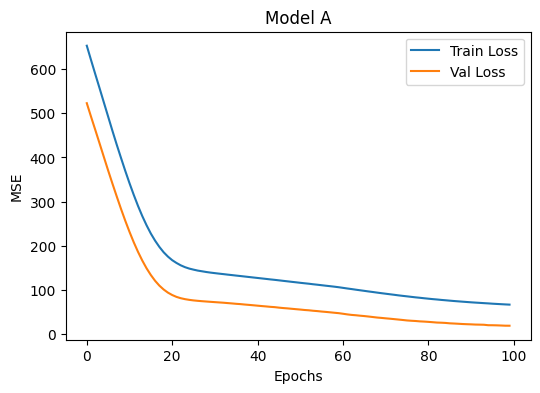

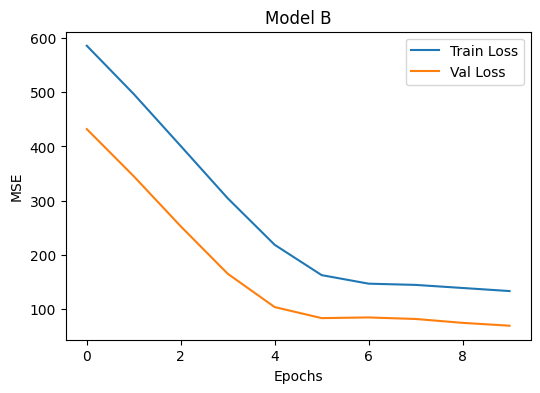

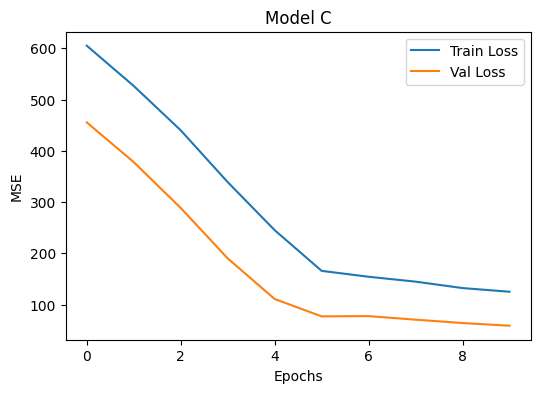

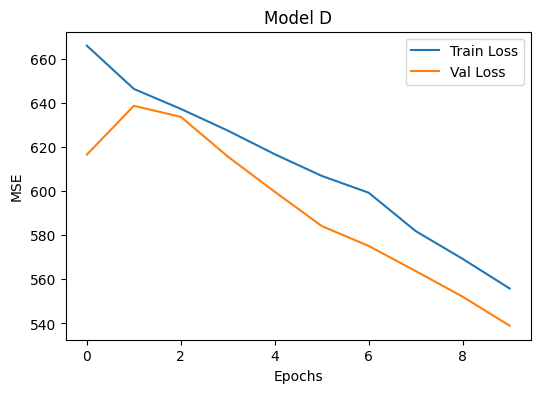

In [15]:
# Plot training curves for each model
for name in history:
    plt.figure(figsize=(6, 4))
    plt.plot(history[name].history['loss'], label='Train Loss')
    plt.plot(history[name].history['val_loss'], label='Val Loss')
    plt.title(name)
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

## 5: Choose best model and evaluate with test data: